In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import mpl_toolkits.mplot3d as a3
from pathlib import Path
from tqdm import tqdm

from common import Intrinsics

In [2]:
def generate_rays(pose, intr, size=1):
    x_coords = np.arange(intr.w, dtype=np.float32)
    y_coords = np.arange(intr.h, dtype=np.float32)
    w, h = intr.w, intr.h
    dx, dy = 0, 0
    pose_r, pose_t = pose[:3, :3], pose[:3, 3]

    i, j = np.meshgrid(x_coords, y_coords, indexing='xy')
    k = np.ones_like(i)

    # Pixel coords to camera frame
    dirs = np.stack([(i - intr.cx) / intr.fx, (j - intr.cy) / intr.fy, k], axis=-1)
    
    # Camera frame to world frame
    rays_d = np.einsum('ij, hwj -> hwi', pose_r, dirs)
    rays_d = rays_d / np.linalg.norm(rays_d, axis=2, keepdims=True) * size
    return rays_d

In [3]:
def load_llff(root_path):
    # Correct camera coords to canonical system
    # +X: right, +Y: bottom, +Z: front
    camera_t = np.array([[0, 0, -1], [0, -1, 0], [-1, 0, 0]])
    
    # Correct world coords to canonical system
    # +X: right, +Y: front, +Z: top
    pose_t = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, -1, 0, 0], [0, 0, 0, 1]])
    
    poses_path = Path(root_path) / 'poses_bounds.npy'
    
    poses_arr = np.load(poses_path)
    poses, bounds = np.split(poses_arr, [15, ], axis=1)
    poses = poses.reshape(-1, 3, 5)
    h, w, f = poses[0, :, 4]
    intr = Intrinsics(h, w, f, f, w // 2, h // 2)
    
    # (N, 3, 5) -> (N, 4, 4)
    poses = np.concatenate([poses[:, :, :4], np.tile([0, 0, 0, 1], (len(poses), 1, 1))], axis=1)
    poses = np.einsum('ij, njk -> nik', pose_t, poses[:, :, :4])[:, :3]
    
    # (N, 3, 4) -> (N, 3, 3)
    poses[:, :, :3] = np.einsum('ij, njk -> nik', camera_t, poses[:, :, :3])
    return poses, intr

In [4]:
def load_nsvf(root_path):
    pose_dir = Path(root_path) / 'pose'
    intrinsics_path = Path(root_path) / 'intrinsics.txt'
    pose_paths = sorted(pose_dir.glob('0_*.txt'))
    
    poses = np.zeros((len(pose_paths), 3, 4))
    for i, path in enumerate(pose_paths):
        vals = [[float(w) for w in line.strip().split()] for line in open(path)]
        poses[i] = np.array(vals).astype(np.float32)[:3]
    
    with open(intrinsics_path, 'r') as file:
        f, cx, cy, _ = map(float, file.readline().split())
    intr = Intrinsics(800, 800, f, f, cx, cy)
    
    return poses, intr

In [5]:
def load_replica(root_path):
    pose_path = Path(root_path) / 'cameras.json'
    camera_t = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
    pose_t = np.array([[0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1]])
    flen = 256.
    
    with open(pose_path) as f:
        poses_list = json.load(f)
    
    poses = np.stack([p['Rt'] for p in poses_list], axis=0)
    for i in range(len(poses)):
        R, t = np.copy(poses[i, :3, :3]), np.copy(poses[i, :3, 3])
        poses[i, :3, 3] = -np.matmul(R.T, t)
        poses[i, :3, :3] = np.matmul(camera_t, R).T
    
    poses = np.einsum('ij, njk -> nik', pose_t, poses)[:, :3]
    intr = Intrinsics(512, 512, flen, flen, 256.0, 256.0)
    print(intr)
    
    return poses[:, :3], intr

In [6]:
# poses, intr = load_llff('/home/hwpang/datasets/nerf_llff_data/fern')
# poses, intr = load_llff('/home/hwpang/datasets/nerf_llff_data/room')
# poses, intr = load_nsvf('/home/hwpang/datasets/nsvf/Synthetic_NeRF/Chair')
poses, intr = load_replica('/home/hwpang/datasets/replica_all/train/00')

origins = poses[:, :, 3]
dests_lr = np.zeros((2, len(origins), 3))
dests_corner = np.zeros((4, len(origins), 3))

for i, pose in tqdm(enumerate(poses), total=len(poses)):
    dests = generate_rays(pose, intr, size=1)
    
    dests_lr[0, i] = dests[int(intr.w / 2), 0]
    dests_lr[1, i] = dests[int(intr.w / 2), -1]
    
    dests_corner[0, i] = dests[0, 0]
    dests_corner[1, i] = dests[0, -1]
    dests_corner[2, i] = dests[-1, 0]
    dests_corner[3, i] = dests[-1, -1]

Intrinsics(h=512, w=512, fx=256.0, fy=256.0, cx=256.0, cy=256.0)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.62it/s]


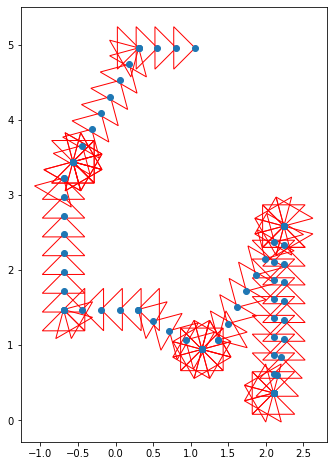

In [7]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16, 8))

for i in range(len(origins)):
    origin = origins[i]
    left, right = dests_lr[0, i], dests_lr[1, i]
    tri_coords = np.stack([origin, origin + left * 0.4, origin + right * 0.4], axis=0)[:, [0, 1]]
    ax.add_patch(plt.Polygon(tri_coords, edgecolor='red', fill=False))

ax.scatter(origins[:, 0], origins[:, 1])

ax.set_aspect('equal')
fig.show()

In [8]:
bbox_vertices = np.array([
    [-0.55671, 5.9886, -0.17978],
    [3.3032, 5.2376, -0.13512],
    [2.1874, -0.44488, 0.74164],
    [-1.6725, 0.30619, 0.69699],
    [-1.7222, -0.11495, -2.0957],
    [2.1378, -0.86602, -2.051],
    [3.2536, 4.8164, -2.9278],
    [-0.60635, 5.5675, -2.9724]
])

faces = [
    [0, 1, 2], [0, 2, 3], [2, 4, 3], [2, 5, 4], [1, 5, 2], [1, 6, 5],
    [0, 6, 1], [0, 7, 6], [3, 7, 0], [3, 4, 7], [4, 5, 6], [4, 6, 7]
]

<IPython.core.display.Javascript object>


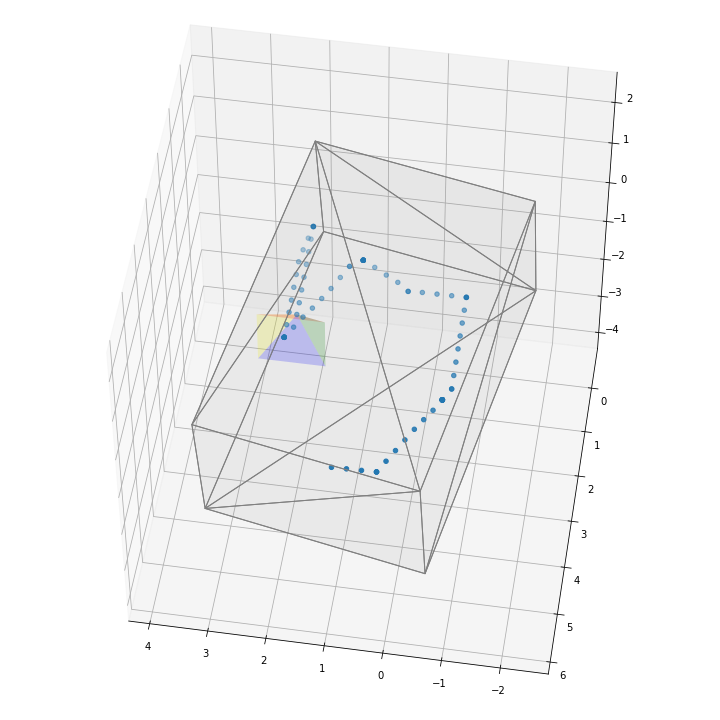

interactive(children=(IntSlider(value=49, description='frame', max=99), FloatSlider(value=5.0, description='si…

In [9]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
ax = a3.Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.set_box_aspect((1, 1, 1))

ax_max, ax_min = np.max(origins, axis=0), np.min(origins, axis=0)
ax_center = (ax_max + ax_min) / 2
radius = max(ax_max - ax_min) / 2 * 1.5
ax.set_xlim((ax_center[0] - radius, ax_center[0] + radius))
ax.set_ylim((ax_center[1] - radius, ax_center[1] + radius))
ax.set_zlim((ax_center[2] - radius, ax_center[2] + radius))

dummy = np.eye(3)  # Dynamically change later
top_face = a3.art3d.Poly3DCollection(dummy, facecolor='red', alpha=0.2)
left_face = a3.art3d.Poly3DCollection(dummy, facecolor='green', alpha=0.2)
bottom_face = a3.art3d.Poly3DCollection(dummy, facecolor='blue', alpha=0.2)
right_face = a3.art3d.Poly3DCollection(dummy, facecolor='yellow', alpha=0.2)

for f in [top_face, left_face, bottom_face, right_face]:
    ax.add_collection3d(f)

def set_verts(i, size=1):
    c0 = origins[i]
    c1, c2, c3, c4 = [origins[i] + dests_corner[j, i] * size for j in range(4)]
    top_face.set_verts([c0, c1, c2])
    left_face.set_verts([c0, c1, c3])
    bottom_face.set_verts([c0, c3, c4])
    right_face.set_verts([c0, c2, c4])

def update(frame, size):
    set_verts(frame, size)
    fig.canvas.draw()

ax.scatter3D(origins[:, 0], origins[:, 1], origins[:, 2])

for f in faces:
    ax.add_collection3d(a3.art3d.Poly3DCollection(bbox_vertices[f], edgecolor='gray', facecolor='gray', alpha=0.05))

interact(update, frame=(0, len(origins)-1), size=(0, 10.0));